# Step-by-step demonstration

## Lib Imports and configurations

In [1]:
# %matplotlib notebook
# %matplotlib inline 
%load_ext autoreload
%autoreload 2

import sys
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
from ruptures.metrics import precision_recall, meantime
import scipy.stats as ss

sys.path.append("Codes/")
import TMPD_utils
import TMPD_class

import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 150)
# pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
pd.options.display.float_format = '{:.4f}'.format


## Loading event log

In [2]:
# Mapping all event_logs paths
logs_path = glob.glob("Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs/*/*k.*")

# Removing the logs with 2500 and 5000 events (based on Maaradji paper)
logs_path = [x for x in logs_path if "7.5" in x or "10" in x]

# Showing mapped paths
print("How many logs? ", len(logs_path))
pd.DataFrame(logs_path)

How many logs?  36


,0
0,Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\cb\cb10k.mxml
1,Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\cb\cb7.5k.mxml
2,Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\cd\cd10k.mxml
3,Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\cd\cd7.5k.MXML
4,Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\cf\cf10k.mxml
5,Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\cf\cf7.5k.mxml
6,Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\cm\cm10k.mxml
7,Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\cm\cm7.5k.mxml
8,Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\cp\cp10k.mxml
9,Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\cp\cp7.5k.mxml


<!-- ![Alt text](../Images/Concept_drift_firstcycle_steps_eng.png "General steps") -->

In [3]:
# Loading first event log
log_path = logs_path[0]
print(log_path.split("\\")[-1].split(".")[0])
event_log = TMPD_utils.parse_mxml(log_path)

# This is a specifc step for this event log that separates in different rows the start and end of an activity. As we will only use one timestamp, we are filtering only the row representing the end of an activity.  
event_log = event_log[event_log.EventType == "complete"]

# Save original event index
event_log = event_log.reset_index(names='original_index') 

# Create an id based on the order of the event in the raw event log
event_log["Event_order_id"] = event_log.index

# This is a specifc step for this event log, because it have duplicated case ids. So we create a new case id.
event_log["Trace_order"] = TMPD_utils.cumulative_counting(event_log["CaseId"])

# Showing loaded event log
print("Total events: ", len(event_log))
print("Total cases: ", len(event_log.groupby('CaseId')))
print("Total activities: ", len(event_log.groupby('Activity')))
event_log.head(15)

cb10k
Total events:  100721
Total cases:  10000
Total activities:  19


,original_index,CaseId,WorkflowModelElement,EventType,Timestamp,Originator,Activity,Event_order_id,Trace_order
0,1,b1_503,Loan__application_received,complete,2004-03-16T12:30:00.000+00:00,NaN,Loan__application_received,0,0
1,3,b1_503,Check__application__form_completeness,complete,2004-03-16T12:38:33.151+00:00,NaN,Check__application__form_completeness,1,0
2,6,b1_503,Appraise_property,complete,2004-03-16T12:48:29.200+00:00,NaN,Appraise_property,2,0
3,7,b1_503,Check_credit_history,complete,2004-03-16T12:53:00.728+00:00,NaN,Check_credit_history,3,0
4,9,b1_503,Assess_loan_risk,complete,2004-03-16T14:02:18.419+00:00,NaN,Assess_loan_risk,4,0
5,11,b1_503,Assess_eligibility,complete,2004-03-16T14:36:07.005+00:00,NaN,Assess_eligibility,5,0
6,13,b1_503,Reject_application,complete,2004-03-16T15:21:24.281+00:00,NaN,Reject_application,6,0
7,15,b1_503,Loan_application_rejected,complete,2004-03-16T15:21:24.281+00:00,NaN,Loan_application_rejected,7,0
8,17,b1_501,Loan__application_received,complete,2004-03-16T11:30:00.000+00:00,NaN,Loan__application_received,8,1
9,19,b1_501,Check__application__form_completeness,complete,2004-03-16T11:33:07.015+00:00,NaN,Check__application__form_completeness,9,1


## Step 1 - Instantiating class and setting event log

In [4]:
# Iniatializing the TMPD_class
TMPD_instance = TMPD_class.TMPD(scenario='offline')

# Setting the transition log
TMPD_instance.set_transition_log(event_log, case_id='Trace_order', activity_key='Activity', timestamp_key='Timestamp', timestamp_format=None, other_columns_keys=[])

# Executing the transition log
TMPD_instance.run_transition_log()

# Showing the transition log created
print(len(TMPD_instance.get_transition_log()))
TMPD_instance.get_transition_log().head(15)

90721


,original_index,case_id,activity_from,timestamp_from,activity_to,timestamp_to,transition_id,case_order
0,0,0,Loan__application_received,2004-03-16T12:30:00.000+00:00,Check__application__form_completeness,2004-03-16T12:38:33.151+00:00,0,0
1,1,0,Check__application__form_completeness,2004-03-16T12:38:33.151+00:00,Appraise_property,2004-03-16T12:48:29.200+00:00,1,1
2,2,0,Appraise_property,2004-03-16T12:48:29.200+00:00,Check_credit_history,2004-03-16T12:53:00.728+00:00,2,2
3,3,0,Check_credit_history,2004-03-16T12:53:00.728+00:00,Assess_loan_risk,2004-03-16T14:02:18.419+00:00,3,3
4,4,0,Assess_loan_risk,2004-03-16T14:02:18.419+00:00,Assess_eligibility,2004-03-16T14:36:07.005+00:00,4,4
5,5,0,Assess_eligibility,2004-03-16T14:36:07.005+00:00,Reject_application,2004-03-16T15:21:24.281+00:00,5,5
6,6,0,Reject_application,2004-03-16T15:21:24.281+00:00,Loan_application_rejected,2004-03-16T15:21:24.281+00:00,6,6
7,8,1,Loan__application_received,2004-03-16T11:30:00.000+00:00,Check__application__form_completeness,2004-03-16T11:33:07.015+00:00,7,0
8,9,1,Check__application__form_completeness,2004-03-16T11:33:07.015+00:00,Appraise_property,2004-03-16T11:54:59.077+00:00,8,1
9,10,1,Appraise_property,2004-03-16T11:54:59.077+00:00,Check_credit_history,2004-03-16T12:20:07.806+00:00,9,2


## Step 2 - Setting Window Strategy

In [5]:
# Setting the window strategy parameters
TMPD_instance.set_windowing_strategy(window_size_mode = 'Fixed', window_size = 4000, window_ref_mode = 'Fixed', overlap = True, sliding_step = 200, continuous = True)

# Executing the window strategy indexation
TMPD_instance.run_windowing_strategy()

# Showing the windows indexes
dict(list(TMPD_instance.get_windowing_strategy().items())[:15])

{0: {'start': 0, 'end': 4000, 'window_index': 0},
 1: {'start': 200, 'end': 4200, 'window_index': 1},
 2: {'start': 400, 'end': 4400, 'window_index': 2},
 3: {'start': 600, 'end': 4600, 'window_index': 3},
 4: {'start': 800, 'end': 4800, 'window_index': 4},
 5: {'start': 1000, 'end': 5000, 'window_index': 5},
 6: {'start': 1200, 'end': 5200, 'window_index': 6},
 7: {'start': 1400, 'end': 5400, 'window_index': 7},
 8: {'start': 1600, 'end': 5600, 'window_index': 8},
 9: {'start': 1800, 'end': 5800, 'window_index': 9},
 10: {'start': 2000, 'end': 6000, 'window_index': 10},
 11: {'start': 2200, 'end': 6200, 'window_index': 11},
 12: {'start': 2400, 'end': 6400, 'window_index': 12},
 13: {'start': 2600, 'end': 6600, 'window_index': 13},
 14: {'start': 2800, 'end': 6800, 'window_index': 14}}

## Step 3 - Setting Process Representation (using Transition Matrix)

In [6]:
# Setting the Transition Matrix (TM) process representation
TMPD_instance.set_process_representation(threshold_anomaly=0
                                    , control_flow_features={'frequency', 'probability', 'causality', 'parallel'}
                                    , time_features={} #{'avg_time':'timestamp', 'time_std':'timestamp'}
                                    , resource_features={}
                                    , data_features={})

# Executing the process_representation using all dataset just for an example
TMPD_instance.run_process_representation(TMPD_instance.transition_log)

# Showing the process representation created
TMPD_instance.get_process_representation().head(15)

frequency  \
activity_from                         activity_to                                       
Appraise_property                     Assess_eligibility                         2443   
                                      Assess_loan_risk                           2580   
                                      Check_credit_history                       4977   
Approve_application                   Loan__application_approved                 2560   
Assess_eligibility                    Prepare_acceptance_pack                    3717   
                                      Reject_application                         4972   
                                      Send_acceptance_pack                        626   
                                      Send_home_insurance_quote                   685   
Assess_loan_risk                      Appraise_property                          2443   
                                      Assess_eligibility                         7557   
Cancel_application                    Loan__application_canceled                 2468   
Check__application__form_completeness Appraise_property                          4977   
                                      Check_credit_history                       5023   
                                      Return_application_back_to_applicant       1077   
Check_credit_history                  Appraise_property                          2580   

                                                                            parallel  \
activity_from                         activity_to                                      
Appraise_property                     Assess_eligibility                           0   
                                      Assess_loan_risk                             1   
                                      Check_credit_history                         1   
Approve_application                   Loan__application_approved                   0   
Assess_eligibility                    Prepare_acceptance_pack                      0   
                                      Reject_application                           0   
                                      Send_acceptance_pack                         0   
                                      Send_home_insurance_quote                    0   
Assess_loan_risk                      Appraise_property                            1   
                                      Assess_eligibility                           0   
Cancel_application                    Loan__application_canceled                   0   
Check__application__form_completeness Appraise_property                            0   
                                      Check_credit_history                         0   
                                      Return_application_back_to_applicant         0   
Check_credit_history                  Appraise_property                            1   

                                                                            probability  \
activity_from                         activity_to                                         
Appraise_property                     Assess_eligibility                         0.2443   
                                      Assess_loan_risk                           0.2580   
                                      Check_credit_history                       0.4977   
Approve_application                   Loan__application_approved                 1.0000   
Assess_eligibility                    Prepare_acceptance_pack                    0.3717   
                                      Reject_application                         0.4972   
                                      Send_acceptance_pack                       0.0626   
                                      Send_home_insurance_quote                  0.0685   
Assess_loan_risk                      Appraise_property                          0.2443   
                                      Assess_eligibility        

## Step 4 - Setting Change Representation

In [7]:
# Defining the change features
change_features_strategy_dict = {
    'delta_matrix_strategy': 
        {
            'frequency_delta' : {'process_feature':'frequency', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'probability_delta' : {'process_feature':'probability', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'causality_delta' : {'process_feature':'causality', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'parallel_delta' : {'process_feature':'parallel', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'frequency_delta_percentage' : {'process_feature':'frequency', 'method':'percentage'}
            , 'prob_freq_delta_weight' : {'process_feature':'probability', 'method':'aggregation_weight', 'agg_function' : 'sum', 'weight_feature' : 'frequency'}
            # , 'avg_time_delta' : {'process_feature':'avg_time', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'time_std_delta' : {'process_feature':'time_std', 'method':'aggregation', 'agg_function' : 'sum'}
        }
    , 'statistic_test_strategy' : 
        {
            'frequency_gtest_pvalue' : {'process_feature':'frequency', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            , 'frequency_cramersv' : {'process_feature':'frequency', 'method':'cramers_v', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
        }
    }

# Setting Change Representation
TMPD_instance.set_change_representation(change_features_strategy_dict)

# Executing the Change Representation using the window strategy
TMPD_instance.run_change_representation()

# Showing the Change Representation created
TMPD_instance.get_change_representation().head(15)

,start,end,window_index,reference_window_index,frequency_delta,probability_delta,frequency_delta_percentage,prob_freq_delta_weight,frequency_gtest_pvalue,frequency_cramersv
0,0,4000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,200,4200,1,0,58.0000,0.0862,0.0073,0.3130,1.0000,0.0000
2,400,4400,2,0,92.0000,0.1327,0.0115,0.6892,1.0000,0.0000
3,600,4600,3,0,88.0000,0.1425,0.0110,0.7653,1.0000,0.0000
4,800,4800,4,0,110.0000,0.1453,0.0138,0.9898,1.0000,0.0000
5,1000,5000,5,0,120.0000,0.2398,0.0150,1.9414,1.0000,0.0000
6,1200,5200,6,0,130.0000,0.2102,0.0163,1.3878,1.0000,0.0000
7,1400,5400,7,0,136.0000,0.2303,0.0170,1.8600,1.0000,0.0000
8,1600,5600,8,0,120.0000,0.1962,0.0150,1.1673,1.0000,0.0000
9,1800,5800,9,0,120.0000,0.1957,0.0150,1.1251,1.0000,0.0000


## Step 5 - Setting Detection Task

In [8]:
# Defining detection strategies
detection_task_strategy_dict = {
    'time_series_strategy': 
    {
        'cpd_frequency_delta' : {'change_features':['frequency_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_prob_freq_delta' : {'change_features':['prob_freq_delta_weight'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_causality_delta' : {'change_features':['causality_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_parallel_delta' : {'change_features':['parallel_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_avg_time_delta' : {'change_features':['avg_time_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_time_std_delta' : {'change_features':['time_std_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
    }
    , 'threshold_strategy' : 
    {
        'gtest_frequency' : {'change_features':['frequency_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' : '3'}
        , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
        # , 'fixed_frequency_delta_percentage' : {'change_features':['frequency_delta_percentage'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
    }
}

# Setting Detection Task
TMPD_instance.set_detection_task(detection_task_strategy_dict)

# Executing the Detection Task
TMPD_instance.run_detection_task()

# Showing Detection Task Results
TMPD_instance.get_detection_task()


,detection_strategy,detection_feature,detection_results
0,time_series_strategy,cpd_frequency_delta,"[33, 80, 129, 170, 216, 257, 313, 353, 406, 434]"
1,time_series_strategy,cpd_prob_freq_delta,"[40, 77, 132, 169, 220, 257, 314, 350, 407, 434]"
2,time_series_strategy,cramersv_frequency,"[35, 83, 129, 175, 216, 264, 309, 356, 403, 434]"
3,threshold_strategy,cramersv_frequency,"[32, 85, 125, 178, 212, 267, 305, 357, 398, 434]"
4,threshold_strategy,gtest_frequency,"[31, 85, 124, 178, 212, 268, 305, 358, 397, 434]"


In [9]:
# Grounding truth
log_size = event_log['Trace_order'].nunique()
ground_truth_traces_indexes = list(range(int(log_size/10), log_size, int(log_size/10)))

transition_log = TMPD_instance.get_transition_log()
ground_truth_events_indexes = transition_log[transition_log['case_id'].isin(ground_truth_traces_indexes)].groupby('case_id').first()['transition_id'].to_list()

# signals_indexes = signals.reset_index()
signals = TMPD_instance.get_change_representation()
ground_truth = []
for ground_truth_events_index in ground_truth_events_indexes:
    ground_truth.extend(signals[(signals['start'] <= ground_truth_events_index) 
                & (signals['end'] >= ground_truth_events_index)].head(1).index.to_list())
ground_truth = ground_truth + [len(signals)]
print("ground_truth: ", ground_truth)

ground_truth:  [27, 72, 118, 162, 209, 253, 299, 343, 390, 434]


In [10]:
### Validation metrics
margin_error_defined=3
detection_task_results = TMPD_instance.get_detection_task()
for index, row in detection_task_results.iterrows():
    try:
        detection_task_results.loc[index, 'ground_truth'] = str(ground_truth)

        # smooth = int(detection_task_strategy_dict[row['detection_strategy']][row['detection_feature']]['smooth'])

        # Margin of error give more margin to overlap if used.
        margin_error = int(margin_error_defined + 1)  if TMPD_instance.overlap == False else int(margin_error_defined + 1 + TMPD_instance.window_size/TMPD_instance.sliding_step)

        precision, recall = precision_recall(ground_truth, row['detection_results'], margin=margin_error)

        f1 = round(ss.hmean([precision, recall]),2)
        detection_task_results.loc[index, 'f1'] = f1
        
        delay = round(meantime(ground_truth, row['detection_results']), 2)
        detection_task_results.loc[index, 'delay'] = delay

    except Exception as e:
        print("Error:", e)
        detection_task_results.loc[index, 'ground_truth'] = str(ground_truth)
        detection_task_results.loc[index, 'f1'] = np.nan
        detection_task_results.loc[index, 'delay'] = np.nan
    
detection_task_results

,detection_strategy,detection_feature,detection_results,ground_truth,f1,delay
0,time_series_strategy,cpd_frequency_delta,"[33, 80, 129, 170, 216, 257, 313, 353, 406, 434]","[27, 72, 118, 162, 209, 253, 299, 343, 390, 434]",1.0000,9.3300
1,time_series_strategy,cpd_prob_freq_delta,"[40, 77, 132, 169, 220, 257, 314, 350, 407, 434]","[27, 72, 118, 162, 209, 253, 299, 343, 390, 434]",1.0000,10.3300
2,time_series_strategy,cramersv_frequency,"[35, 83, 129, 175, 216, 264, 309, 356, 403, 434]","[27, 72, 118, 162, 209, 253, 299, 343, 390, 434]",1.0000,10.7800
3,threshold_strategy,cramersv_frequency,"[32, 85, 125, 178, 212, 267, 305, 357, 398, 434]","[27, 72, 118, 162, 209, 253, 299, 343, 390, 434]",1.0000,9.5600
4,threshold_strategy,gtest_frequency,"[31, 85, 124, 178, 212, 268, 305, 358, 397, 434]","[27, 72, 118, 162, 209, 253, 299, 343, 390, 434]",1.0000,9.4400


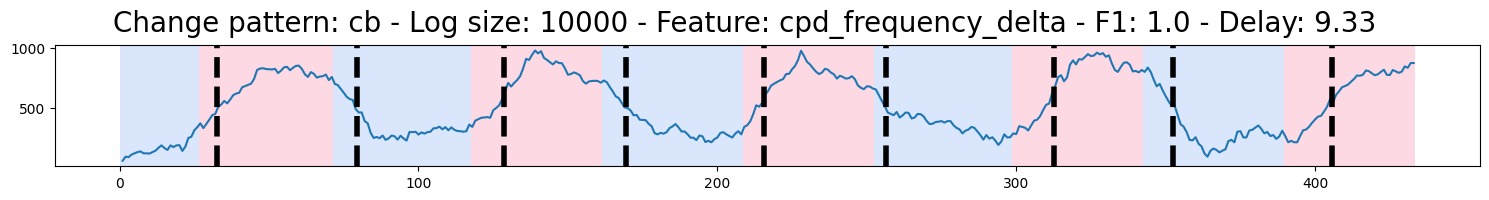

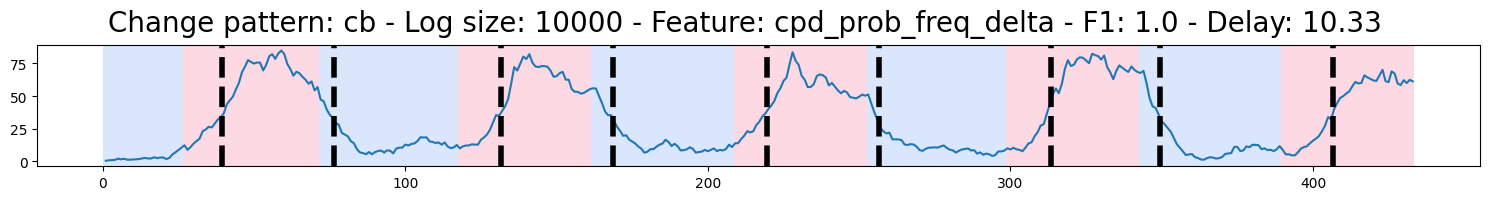

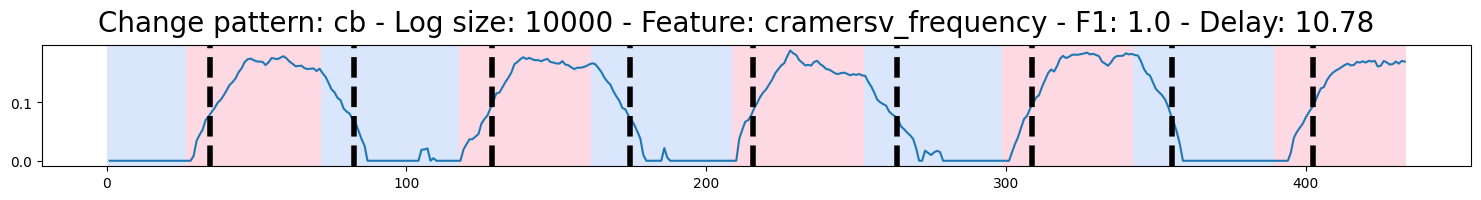

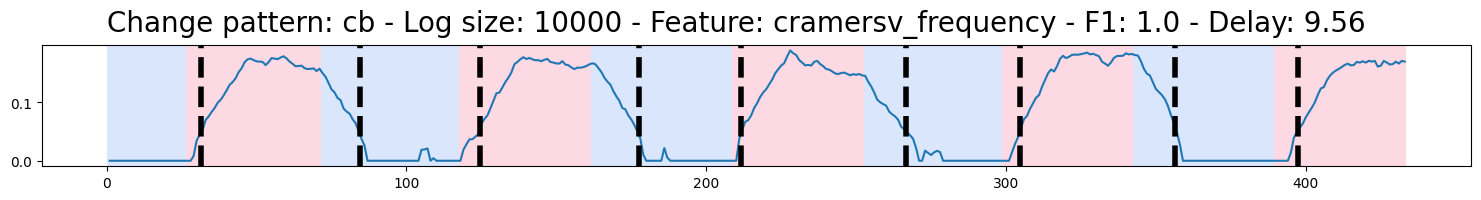

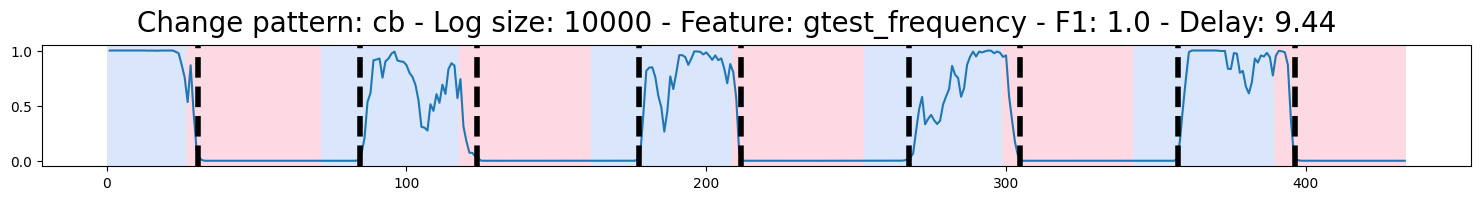

In [27]:
# Display Detection Task Results 

for result in detection_task_results.itertuples():
    fig, axarr = rpt.display(signal = TMPD_instance.get_change_representation()[TMPD_instance.detection_task_strategy_dict[result.detection_strategy][result.detection_feature]['change_features']]
                , true_chg_pts=ground_truth
                , computed_chg_pts = result.detection_results
                , computed_chg_pts_color = "k"
                , computed_chg_pts_linewidth = 4
                , computed_chg_pts_linestyle = "--"
                , computed_chg_pts_alpha = 1
                , figsize=(15, 2)
                )
    plt.suptitle("Change pattern: " + log_path.split("\\")[-2] 
                 + " - Log size: " + str(log_size)
                 + " - Feature: " + result.detection_feature
                 + " - F1: " + str(result.f1) 
                 + " - Delay: " + str(result.delay)
                 , fontsize=20)
    plt.subplots_adjust(top=0.8)
    plt.show()

## Step 6a - Setting Localization Task

In [12]:
# TODO

## Step 6b - Setting Characterization Task

In [13]:
# TODO

## Step 6c - Setting Explanation Task

In [14]:
# TODO